In [250]:
import numpy as np
from random import choice, random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from typing import Tuple
from tqdm import tqdm

In [329]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.03,
        decay_rate: float = 0.005
    ):
        # Parámetros de Q-learning
        self.alpha = alpha
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = {}
        # Memoria corta
        self.short_term_memory = {}
        
        # Contadores
        self.steps = 0
        
        self._init_q_table_and_stm()
        
        
    
    def _init_q_table_and_stm(self):
        """Inicializa la Q-table con ceros para todas las combinaciones estado-acción"""
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                state = (row, col)
                self.q_knowledge[state] = {action: 0.0 for action in self.actions}
                # Inicializa memoria corta
                self.short_term_memory[state] = [0]*10
                
    
    def get_next_state(self, base_state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Calcula el próximo estado según la acción"""
        row, col = base_state
        
        if action == 'Up':
            return (max(row-1, 0), col)
        if action == 'Down':
            return (min(row+1, self.n_rows-1), col)
        if action == 'Left':
            return (row, max(col-1, 0))
        if action == 'Right':
            return (row, min(col+1, self.n_cols-1))
        return base_state  # Caso por defecto
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        q_values = self.q_knowledge[state]
        max_q = max(q_values.values())
        
        # Filtra acciones con valor máximo
        best_actions = [a for a, q in q_values.items() if q == max_q]
        return choice(best_actions), max_q
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> None:
        """Actualiza la Q-table según la ecuación de Q-learning"""
        current_q = self.q_knowledge[current_state][action]
        _, next_max_q = self.get_best_action(next_state)
        
        # Ecuación de Q-learning tradicional
        new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
        self.q_knowledge[current_state][action] = new_q
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random() < epsilon:
            # Exploración: acciones válidas (que cambian el estado)
            valid_actions = [
                a for a in self.actions
                if self.get_next_state(self.current_state, a) != self.current_state
            ]
            return choice(valid_actions)
        
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate*step)
    
    def move(self, reward: float, action: str) -> None:
        """
        Realiza un paso completo de Q-learning:
        1. Actualiza Q-table con la observación actual
        2. Cambia al nuevo estado
        """
        # Actualización Q-learning
        
        next_state = self.get_next_state(self.current_state, action)
        
        new_q = self.update_q_value(
                    current_state=self.current_state,
                    action=action,
                    reward=reward,
                    next_state=next_state
                )
        
        self.short_term_memory[self.current_state] = self.short_term_memory[self.current_state][1:] + [new_q]
        
        # Actualizar estado y contadores
        self.current_state = next_state
        self.steps += 1
        
        # STM
        base_memo = self.short_term_memory[(1,0)][:-2]
        sign = self.short_term_memory[(1,0)][-1] - np.mean(base_memo)
        criteria = abs(sign) > 5*np.std(base_memo)
        
        if criteria:
            criteria = 'pos' if sign > 0 else 'neg'
                
        return new_q, criteria
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial"""
        self.current_state = self.initial_state
        self.steps = 0

    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"

### With Memory

In [433]:
N_ROWS = 5
N_COLS = 5
GRID_WORLD = np.zeros((N_ROWS, N_COLS))-1

GOAL_STATE_1 = (0, 0)
GOAL_STATE_2 = (0, 4)
GRID_WORLD[GOAL_STATE_1] = 100 
GRID_WORLD[GOAL_STATE_2] = -1

EXPLOTATION = 0.05

# Inicialización
agent = AdaptativeAgent(
    initial_state=(4,2),
    actions=['Up', 'Down', 'Left', 'Right'],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=0.007
)

learning_curve = []
exploration_curve = []
step_changes = []
episode_changes = [50]

q_learning = 0
episode = 0
ite = 0
c = 0
flag = 0

anomaly_episode = None

# Episodio de entrenamiento
while episode != 100:
    # 1. Elegir acción
    epsilon = agent.epsilon_decay(step=c)
    action = agent.choose_action(epsilon)
    
    next_state = agent.get_next_state(agent.current_state, action)
    reward = GRID_WORLD[next_state]
    
    new_q, criteria = agent.move(reward, action)
    q_learning += new_q
    
    exploration_curve.append([epsilon, new_q])
    
    ite += 1
    c += 1
    
    if criteria and (anomaly_episode != episode):
        print(f"Something happened at {agent.current_state} in episode {episode} ({criteria})")
        if criteria == 'neg' and epsilon < EXPLOTATION:
            c *= .2
            agent.short_term_memory[agent.current_state] = [0]*10
        else:
            c *= 1.1
            
        #agent._init_q_table_and_stm()
        anomaly_episode = episode
    
    if (next_state in [GOAL_STATE_1, GOAL_STATE_2]) or (agent.steps > (N_COLS+N_ROWS)*3):
        episode += 1
        agent.restart()
        learning_curve.append(q_learning/ite)
        
    if episode in episode_changes:
        GRID_WORLD[GOAL_STATE_1] = -1
        GRID_WORLD[GOAL_STATE_2] = 100
        
        step_changes.append(ite)

Something happened at (1, 1) in episode 6 (neg)
Something happened at (4, 3) in episode 7 (pos)
Something happened at (4, 3) in episode 8 (pos)
Something happened at (4, 3) in episode 9 (pos)
Something happened at (4, 2) in episode 10 (pos)
Something happened at (3, 2) in episode 11 (pos)
Something happened at (4, 2) in episode 12 (pos)
Something happened at (0, 0) in episode 50 (neg)
Something happened at (4, 3) in episode 51 (neg)
Something happened at (4, 3) in episode 52 (neg)
Something happened at (4, 1) in episode 53 (neg)
Something happened at (1, 1) in episode 77 (neg)
Something happened at (4, 1) in episode 78 (neg)
Something happened at (4, 1) in episode 79 (neg)


In [434]:
eps, q_val = list(zip(*exploration_curve))

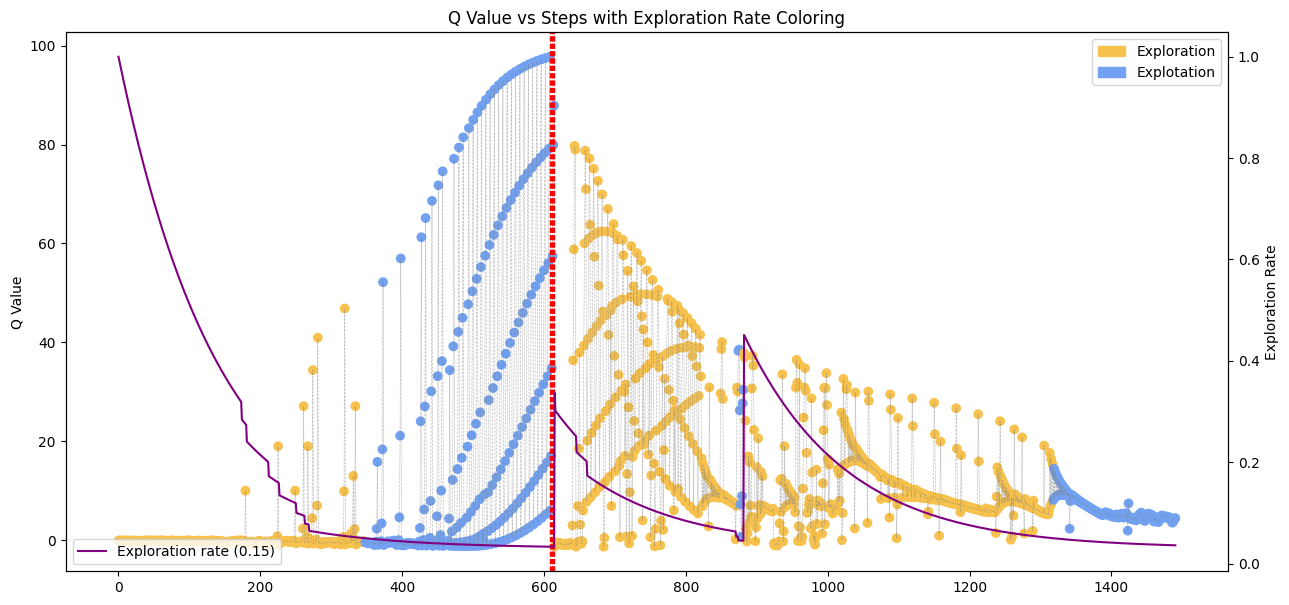

In [448]:
plt.figure(figsize=(15, 7))
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f7c14d'for e in eps])
plt.ylabel('Q Value')

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f7c14d', label='Exploration')
plt.legend(handles=[orange_patch, blue_patch], loc='upper right', fontsize=10)

for change in step_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)

# add another axis
plt.twinx()
plt.plot(eps, label='Exploration rate (0.15)', c='purple')
plt.ylabel('Exploration Rate')
plt.legend(loc='lower left')
plt.xlabel('Steps')

plt.title('Q Value vs Steps with Exploration Rate Coloring')

plt.show()

In [440]:
step_changes

[609, 610, 611, 612, 613, 614]

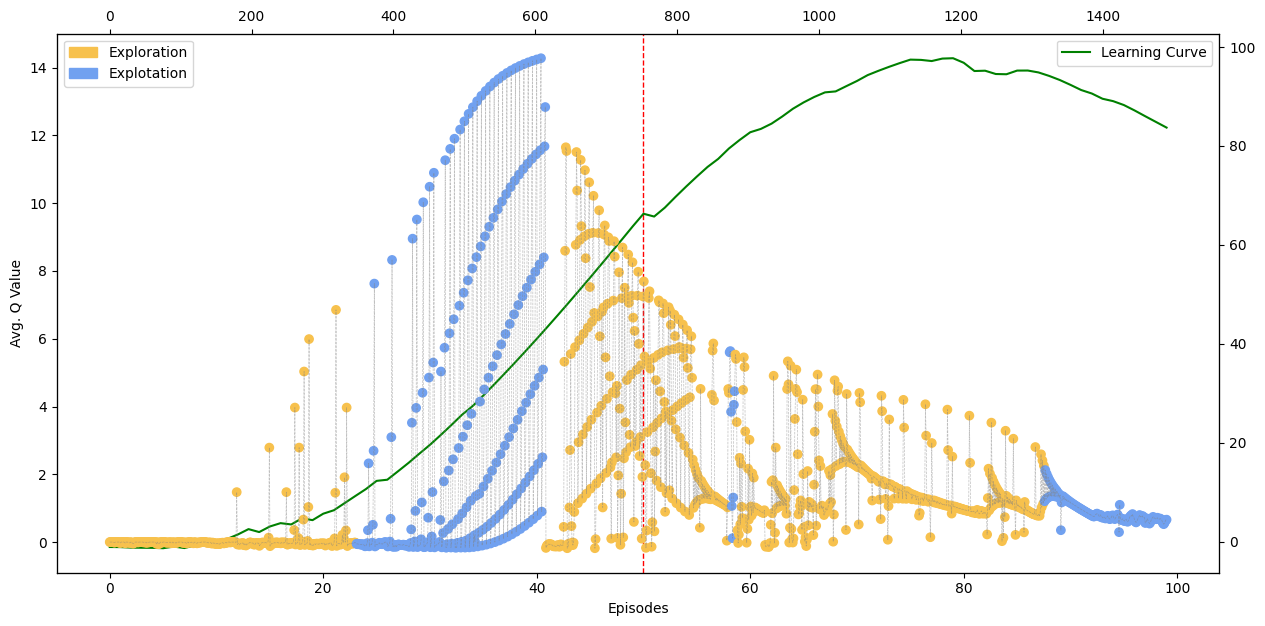

In [445]:
plt.figure(figsize=(15, 7))

plt.plot(learning_curve, c='green', zorder=1000, label='Learning Curve')
plt.ylabel('Avg. Q Value')
plt.xlabel('Episodes')
plt.legend()
for change in episode_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)
    
plt.twinx()
plt.twiny()
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f7c14d'for e in eps])
plt.ylabel('Q Value')

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f7c14d', label='Exploration')
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=10)


plt.show()

In [402]:
POLICY_MAP = np.zeros((N_ROWS, N_COLS))
LABEL_MAP = np.empty((N_ROWS, N_COLS), dtype=object)

for row in range(N_ROWS):
    for col in range(N_COLS):
        action, value = agent.get_best_action((row, col))
        POLICY_MAP[row, col] = value
        LABEL_MAP[row, col] = f'{action}\n{value:.2f}'

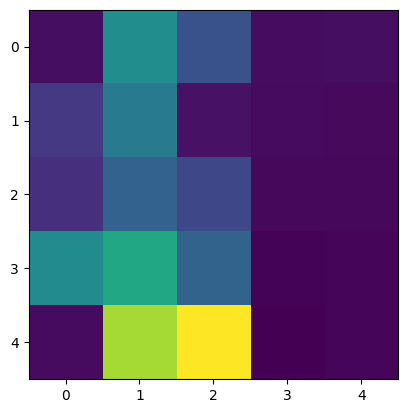

In [403]:
plt.imshow(POLICY_MAP, cmap='viridis', interpolation='nearest')